In [ ]:
# !pip install tensorflow

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/COBOT_v1_test_supervised

/content/drive/MyDrive/COBOT_v1_test_supervised


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Lambda,
    Reshape,
    Conv1D,
    BatchNormalization,
    LeakyReLU,
    SpatialDropout1D,
    MaxPooling1D,
    GlobalMaxPooling1D,
    Dense,
    Dropout,
    concatenate
)

from utils import *
from tensorflow.keras.models import Model
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import random

# Initialize the setting

In [4]:
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Optional: Print GPU details
if tf.config.list_physical_devices('GPU'):
    print("GPU details:", tf.config.list_physical_devices('GPU'))


Num GPUs Available: 1
GPU details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 60 # the length of frames
        self.joint_n = 48 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_num = 19 # the number of class
        self.feat_d = 1128
        self.filters = 16
        self.data_dir = 'data_cobot_new'
C = Config()

In [6]:
def data_generator(T,C,le):
    X_0 = []
    X_1 = []
    Y = []
    for i in tqdm(range(len(T['pose']))):
        p = np.copy(T['pose'][i])
        p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)

        label = np.zeros(C.clc_num)
        label[le.transform(T['label'])[i]] = 1

        M = get_CG(p,C)

        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)
    X_1 = np.stack(X_1)
    Y = np.stack(Y)
    return X_0,X_1,Y

# Building the model

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda, Reshape
from tensorflow.keras.layers import (
    Input,
    Lambda,
    Reshape,
    Conv1D,
    BatchNormalization,
    LeakyReLU,
    SpatialDropout1D,
    MaxPooling1D,
    GlobalMaxPooling1D,
    Dense,
    Dropout,
    concatenate
)
from tensorflow.keras.models import Model

# ----------------------------
# 1. Pose Difference Functions with Explicit Output Shapes
# ----------------------------

import tensorflow as tf

# Decorate your custom functions so that they are registered and can be found during deserialization.

@tf.keras.utils.register_keras_serializable()
def poses_diff(x):
    """
    Compute differences between consecutive frames in x and then use
    tf.image.resize to “restore” the original frame count.

    Assumes x has shape: (batch, frames, joints, dims)
    """
    orig_frames = tf.shape(x)[1]  # e.g., 32
    joint_n = tf.shape(x)[2]      # e.g., 22

    # Compute differences along the frame axis.
    diff = x[:, 1:, ...] - x[:, :-1, ...]

    # Resize the differences back to have the original number of frames.
    resized = tf.image.resize(diff, size=[orig_frames, joint_n])
    return resized

@tf.keras.utils.register_keras_serializable()
def poses_diff_func(x):
    # Simply a wrapper around poses_diff.
    return poses_diff(x)

def poses_diff_output_shape(input_shape):
    # Assuming the input shape is (batch, frames, joints, dims) and we intend to recover it.
    return input_shape


@tf.keras.utils.register_keras_serializable()
def sample_every_2(x):
    """
    Sample every 2nd frame from the input tensor.
    """
    return x[:, ::2, ...]

def sample_every_2_output_shape(input_shape):
    # Given input shape (batch, frames, joints, dims), return (batch, frames//2, joints, dims)
    batch = input_shape[0]
    frames = input_shape[1]
    joints = input_shape[2]
    dims = input_shape[3]
    return (batch, frames // 2, joints, dims)


def pose_motion(P, frame_l):
    """
    For a pose input P (shape: (batch, frame_l, joint_n, joint_d)),
    compute two kinds of differences:
      - Slow differences: computed on the full input.
      - Fast differences: computed on every 2nd frame.

    Then reshape the outputs so that the spatial dimensions are flattened.
    """
    # Slow branch using our registered function:
    P_diff_slow = Lambda(poses_diff_func, output_shape=poses_diff_output_shape)(P)
    P_diff_slow = Reshape((frame_l, -1))(P_diff_slow)

    # Fast branch:
    P_fast = Lambda(sample_every_2, output_shape=sample_every_2_output_shape)(P)
    P_diff_fast = Lambda(poses_diff_func, output_shape=poses_diff_output_shape)(P_fast)
    P_diff_fast = Reshape((frame_l // 2, -1))(P_diff_fast)

    return P_diff_slow, P_diff_fast

# ----------------------------
# 2. Convolutional and Dense Helper Blocks
# ----------------------------

def c1D(x, filters, kernel):
    x = Conv1D(filters, kernel_size=kernel, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x, filters):
    x = c1D(x, filters, 3)
    x = c1D(x, filters, 3)
    return x

def d1D(x, filters):
    x = Dense(filters, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

# ----------------------------
# 3. Build the Feature Model (FM)
# ----------------------------

def build_FM(frame_l=32, joint_n=22, joint_d=2, feat_d=231, filters=16):
    # Define inputs:
    M = Input(shape=(frame_l, feat_d))
    P = Input(shape=(frame_l, joint_n, joint_d))

    # Compute pose differences:
    diff_slow, diff_fast = pose_motion(P, frame_l)

    # Process the M input with a series of 1D convolutions.
    x = c1D(M, filters * 2, 1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x, filters, 3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x, filters, 1)
    x = MaxPooling1D(pool_size=2)(x)
    x = SpatialDropout1D(0.1)(x)

    # Process slow pose differences.
    x_d_slow = c1D(diff_slow, filters * 2, 1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow, filters, 3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow, filters, 1)
    x_d_slow = MaxPooling1D(pool_size=2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)

    # Process fast pose differences.
    x_d_fast = c1D(diff_fast, filters * 2, 1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast, filters, 3)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast, filters, 1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)

    # Concatenate all three processed branches.
    x = concatenate([x, x_d_slow, x_d_fast])
    x = block(x, filters * 2)
    x = MaxPooling1D(pool_size=2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x, filters * 4)
    x = MaxPooling1D(pool_size=2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x, filters * 8)
    x = SpatialDropout1D(0.1)(x)

    return Model(inputs=[M, P], outputs=x)

# ----------------------------
# 4. Build the Final DD-Net Model
# ----------------------------

def build_DD_Net(C):
    """
    Assumes that C is an object or namespace with the following attributes:
      - C.frame_l: number of frames
      - C.feat_d: dimensionality of the M input features
      - C.joint_n: number of joints
      - C.joint_d: joint dimension (e.g., 2)
      - C.filters: base number of filters for the conv layers
      - C.clc_num: number of output classes
    """
    M = Input(name='M', shape=(C.frame_l, C.feat_d))
    P = Input(name='P', shape=(C.frame_l, C.joint_n, C.joint_d))

    FM = build_FM(C.frame_l, C.joint_n, C.joint_d, C.feat_d, C.filters)
    x = FM([M, P])

    x = GlobalMaxPooling1D()(x)
    x = d1D(x, 128)
    x = Dropout(0.5)(x)
    x = d1D(x, 128)
    x = Dropout(0.5)(x)
    x = Dense(C.clc_num, activation='softmax')(x)

    model = Model(inputs=[M, P], outputs=x)
    return model


In [8]:
DD_Net = build_DD_Net(C)
DD_Net.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ M (InputLayer)      │ (None, 60, 1128)  │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ P (InputLayer)      │ (None, 60, 48, 3) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 7, 128)    │    153,088 │ M[0][0], P[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ functional[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,384 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_15      │ (None, 128)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ leaky_re_lu_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,384 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_16      │ (None, 128)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ leaky_re_lu_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 19)        │      2,451 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 189,331 (739.57 KB)

 Trainable params: 187,539 (732.57 KB)

 Non-trainable params: 1,792 (7.00 KB)

## Train and test on GT_split 1

In [9]:
import pickle
from tqdm import tqdm
Train = pickle.load(open(C.data_dir+"/train_new_2.pickle", "rb"))
Test = pickle.load(open(C.data_dir+"/test_new_2.pickle", "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

label_percent = 0.2  # vd: chỉ dùng ..% mỗi class để train

def sample_by_label_percent(data_dict, label_percent, le):
    labels_encoded = le.transform(data_dict['label'])
    class_idx = {}
    for i, lbl in enumerate(labels_encoded):
        class_idx.setdefault(lbl, []).append(i)

    final_choice = []
    for lbl, idx_list in class_idx.items():
        n_sample = max(1, round(len(idx_list) * label_percent))  # ít nhất 1
        final_choice += random.sample(idx_list, n_sample)

    final_choice.sort()

    sampled_data = {
        'pose': [data_dict['pose'][i] for i in final_choice],
        'label': [data_dict['label'][i] for i in final_choice]
    }
    return sampled_data


Train_sampled = sample_by_label_percent(Train, label_percent, le)


X_0,X_1,Y = data_generator(Train_sampled,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

# # fake data
# X_0 = np.random.rand(100,30,1128)
# X_1 = np.random.rand(100,30,48,3)
# Y = np.random.rand(100,20)
# X_test_0 = np.random.rand(100,30,1128)
# X_test_1 = np.random.rand(100,30,48,3)
# Y_test = np.random.rand(100,20)


/tmp/ipython-input-624384208.py:3: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  Train = pickle.load(open(C.data_dir+"/train_new_2.pickle", "rb"))
/tmp/ipython-input-624384208.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the publ

In [10]:
import tensorflow as tf

# Set GPU as the only device
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)


Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
import os
# IMPORTANT: Set this before importing TensorFlow!
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"

import tensorflow as tf
import numpy as np
import time
from tensorflow.keras.callbacks import ModelCheckpoint

# Disable XLA JIT and force eager execution (for debugging purposes)
tf.config.optimizer.set_jit(False)
tf.config.run_functions_eagerly(False)  # Remove this line once debugging is complete

# Enable soft device placement so that if a GPU kernel fails, TF can fallback to CPU
tf.config.set_soft_device_placement(True)

# ------------------------------
# (Optional) Adjust BatchNormalization layers in your model
# If your model uses BatchNormalization, sometimes a very small epsilon can cause issues.
# Here we set the epsilon to 1e-3 for all BN layers in DD_Net.
for layer in DD_Net.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        print(f"Updating {layer.name}: epsilon {layer.epsilon} -> 1e-3")
        layer.epsilon = 1e-3
# ------------------------------

# Define the learning rate
lr = 0.01

# Compile your model with the desired loss, optimizer, and metrics.
DD_Net.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=['accuracy']
)

# Create the ReduceLROnPlateau callback
lrScheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.1,
    patience=10,
    cooldown=5,
    min_lr=1e-5  # or use min_lr=5e-6 if preferred
)

# (Assuming X_0, X_1, Y, X_test_0, X_test_1, Y_test are already defined and properly preprocessed)
checkpoint = ModelCheckpoint(
    'DD_Net_cobo_v1_20%_best.keras',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)
# Train the model on GPU:0
with tf.device("/GPU:0"):
    start_time = time.time()
    history = DD_Net.fit(
        [X_0, X_1],
        Y,
        batch_size=16,   # Adjust as needed
        epochs=400,      # Adjust as needed
        verbose=2,
        shuffle=True,
        callbacks=[lrScheduler, checkpoint],
    )
    print("--- Training completed in %s seconds ---" % (time.time() - start_time))
    model_path = 'DD_Net_cobo_v1_20%.keras'
    DD_Net.save(model_path)

Updating batch_normalization_117: epsilon 0.001 -> 1e-3
Updating batch_normalization_118: epsilon 0.001 -> 1e-3
Epoch 1/400

Epoch 1: loss improved from inf to 3.04707, saving model to DD_Net_cobo_v1_80%_best.keras
65/65 - 16s - 249ms/step - accuracy: 0.1246 - loss: 3.0471 - learning_rate: 0.0100
Epoch 2/400

Epoch 2: loss improved from 3.04707 to 2.41596, saving model to DD_Net_cobo_v1_80%_best.keras
65/65 - 2s - 32ms/step - accuracy: 0.1986 - loss: 2.4160 - learning_rate: 0.0100
Epoch 3/400

Epoch 3: loss improved from 2.41596 to 2.11103, saving model to DD_Net_cobo_v1_80%_best.keras
65/65 - 2s - 32ms/step - accuracy: 0.2668 - loss: 2.1110 - learning_rate: 0.0100
Epoch 4/400

Epoch 4: loss improved from 2.11103 to 1.90606, saving model to DD_Net_cobo_v1_80%_best.keras
65/65 - 3s - 52ms/step - accuracy: 0.2902 - loss: 1.9061 - learning_rate: 0.0100
Epoch 5/400

Epoch 5: loss improved from 1.90606 to 1.82146, saving model to DD_Net_cobo_v1_80%_best.keras
65/65 - 2s - 37ms/step - accura

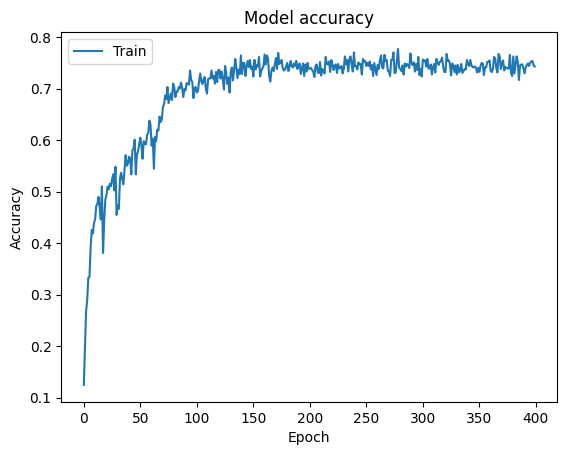

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
# save model
model_path = 'DD_Net_cobo_v1_100%_best.keras'
# DD_Net.save(model_path)


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

custom_objects = {
    'poses_diff_func': poses_diff_func,
    'poses_diff_output_shape': poses_diff_output_shape,
    'sample_every_2': sample_every_2,
    'sample_every_2_output_shape': sample_every_2_output_shape,
}

model = load_model(model_path, custom_objects=custom_objects)

y_prob = model.predict([X_test_0, X_test_1])      # shape (N, C)
y_pred = np.argmax(y_prob, axis=1)
y_test = np.argmax(Y_test, axis=1)

# ===== Top-1 =====
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Top-1 Test accuracy:", acc)
print("Confusion matrix:\n", cm)

# ===== Top-5 =====
# lấy top-5 indices trong mỗi prediction
top5 = np.argsort(y_prob, axis=1)[:, -5:]

top5_hits = [y_test[i] in top5[i] for i in range(len(y_test))]
top5_acc = np.mean(top5_hits)

print("Top-5 Test accuracy:", top5_acc)


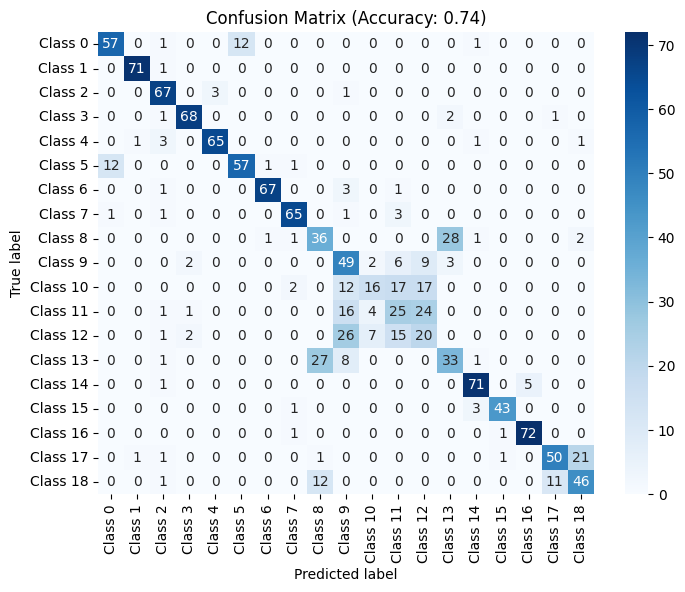

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Vẽ confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=[f"Class {i}" for i in range(cm.shape[0])],
            yticklabels=[f"Class {i}" for i in range(cm.shape[0])])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix (Accuracy: {acc:.2f})')
plt.show()